<a href="https://colab.research.google.com/github/KiaKafaei1/Data_Science_Portfolio/blob/master/Kopi_af_Kopi_af_ver2_network_FoodRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms
import cv2 
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from google.colab import drive
import sys
from torchvision.ops import nms
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# run GPU .... 
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# Loading and filtering 

In [ ]:
def filterData(df):
  # this function filters the dataframe for filenames that have missing zeros and wrong typing of food names
  # input = dataframe
  # output = dataframe
  df['fileID'] = df['fileID'].apply(lambda x: '{0:0>6}'.format(x))
  df=df.replace("boiled potatoesw", "boiled potatoes")
  df=df.replace("chopped lettuce ","chopped lettuce")
  df=df.replace("glass of milk ","glass of milk")
  df=df.replace("slice of bread ","slice of bread")
  df=df.replace("meatballs","meatball")
  return df

In [ ]:
# load csv file 
df = pd.read_csv('/content/drive/My Drive/train_anno_updated.csv')
df=filterData(df)

from sklearn.utils import shuffle
df = shuffle(df)

df_val = pd.read_csv('/content/drive/My Drive/validation_anno_updated.csv')
df_val=filterData(df_val)

In [ ]:
sys.path.append('/content/drive/My Drive')
from prepare_img import prepare_img
from anchorbox_generator import Anchorbox_generator
from class_rpn_vgg16 import ClassRPN, vgg16
from detection import Detection_Network
from nms_detection_loss import nms, sampleRoi
from bbox_predict import bbox_predict
from full_model import full_model
from loss import loss

cuda Tesla T4
cuda Tesla T4
cuda Tesla T4


In [ ]:
# total number of training data:
print('total number of training data: '+str(df.shape[0]))

total number of training data: 2032


#  Main Code with training:

In [ ]:
#train_data = np.loadtxt('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/ImageSets/Main/train.txt', dtype=int)
#train_data.astype(int)

train_iterations = 2032
iter_image = 1

train_total = iter_image*train_iterations

train_total_losses = np.zeros(train_total)
rpn_losses = np.zeros(train_total)
roi_losses = np.zeros(train_total)
rpn_cls_losses = np.zeros(train_total)
roi_cls_losses = np.zeros(train_total)
rpn_loc_losses = np.zeros(train_total)
roi_loc_losses = np.zeros(train_total)
train_iter = np.zeros(train_total)

# HYPERPARAMETERS
# learning rate
lr_rate = 0.00005
# weight decay
weight_decay = 0.0005
# momentum
momentum = 0.9
# the weight of the rpn_loc_loss in total rpn_loss
rpn_lambda = 1
# the weight of the rpn_loi_loss in total roi_loss
roi_lambda = 1
# The amount of samples in anchor_generation
anc_n_sample = 256
# The ratio of objects (not background) sampled in anchor_generation
anc_pos_ratio = 0.5
# The threshold for positive ious (foreground) in anchor_generations
anc_pos_iou_thresh = 0.7
# The threshold for negative ious (background) in anchor_generations
# if neither positive or negative then it is not used to train
anc_neg_iou_thresh = 0.3
# The amount of samples in sampleROI
n_sample = 128
# The ratio of objects (not background) sampled in sampleROI
pos_ratio = 0.25
# The threshold for positive ious (foreground) in sampleROI
pos_iou_thresh = 0.5
# The high threshold for negative ious (background) in smapleROI
neg_iou_thresh_hi = 0.5
# The high threshold for negative ious (background) in smapleROI
neg_iou_thresh_lo = 0.0
# Allowed overlapping area of bboxes in nms
nms_thresh = 0.7
# Amount of samples pre nms
n_train_pre_nms = 12000
# Amount of samples post nms
n_train_post_nms = 2000
# minimum size of bboxes in nms
min_size = 16

# validation iteration
val_iter = np.array([])
val_total_losses = np.array([])

criterion = nn.CrossEntropyLoss(ignore_index = -1)

# Complete network
# VGG16 = vgg16()
net = full_model()

# weight_decay is equal to L2 regularization
# optimizer = torch.optim.Adam(net.parameters(), lr=lr_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=lr_rate, momentum=momentum, weight_decay=weight_decay)

# lables of the food items as lib
lib_lab = {"meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}

it = 0 

for ii in range(train_iterations):
  # print(ii)
  if (ii)%5 == 0:
    print('Iteration: ', ii+1)
    print('Total iterations: ', it+1)

  # Validation
  if (ii+1)%10==0:
    n = (ii+1)%10
    # Prepare image, bbox and labels 
    img1 = cv2.imread('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/JPEGImages/'+str(df_val.fileID.iloc[n])+'.jpg')
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
    # Select a row and transform back to pandas data frame
    temp = df_val.iloc[n]
    tt_val = temp.to_frame()
    tt_val = tt_val.T  

    # FORWARD
    out_val = net(img1, tt_val, anc_n_sample = anc_n_sample, n_sample = n_sample, anc_pos_ratio = anc_pos_ratio, pos_ratio = pos_ratio, pos_iou_thresh = pos_iou_thresh, anc_pos_iou_thresh = anc_pos_iou_thresh, anc_neg_iou_thresh = anc_neg_iou_thresh, neg_iou_thresh_hi=neg_iou_thresh_hi, neg_iou_thresh_lo=neg_iou_thresh_lo, nms_thresh = nms_thresh, n_train_pre_nms = n_train_pre_nms, n_train_post_nms = n_train_post_nms, min_size = min_size)

    # LOSS
    val_total_loss, val_rpn_loss, val_roi_loss, val_roi_cls_loss, val_roi_loc_loss, val_rpn_cls_loss, val_rpn_loc_loss= loss(out_val, criterion, rpn_lambda, roi_lambda)
    val_total_losses = np.append(val_total_losses, val_total_loss.detach().cpu().numpy())
    val_iter = np.append(val_iter, ii+1)

  # Prepare image, bbox and labels 
  img0 = cv2.imread('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/JPEGImages/'+str(df.fileID.iloc[ii])+'.jpg')
  img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
  # Select a row and transform back to pandas data frame
  temp = df.iloc[ii]
  tt = temp.to_frame()
  tt = tt.T


  for t in range(iter_image):
    # FORWARD
    # img = prepare_img(img0)
    # out_map = VGG16(img)
    out = net(img0, tt, anc_n_sample = anc_n_sample, n_sample = n_sample, anc_pos_ratio = anc_pos_ratio, pos_ratio = pos_ratio, pos_iou_thresh = pos_iou_thresh, anc_pos_iou_thresh = anc_pos_iou_thresh, anc_neg_iou_thresh = anc_neg_iou_thresh, neg_iou_thresh_hi=neg_iou_thresh_hi, neg_iou_thresh_lo=neg_iou_thresh_lo, nms_thresh = nms_thresh, n_train_pre_nms = n_train_pre_nms, n_train_post_nms = n_train_post_nms, min_size = min_size)


    # LOSS
    total_loss, rpn_loss, roi_loss, roi_cls_loss, roi_loc_loss, rpn_cls_loss, rpn_loc_loss = loss(out, criterion, rpn_lambda, roi_lambda)


    rpn_losses[it] = rpn_loss
    roi_losses[it] = roi_loss
    rpn_cls_losses[it] = rpn_cls_loss
    roi_cls_losses[it] = roi_cls_loss
    rpn_loc_losses[it] = rpn_loc_loss
    roi_loc_losses[it] = roi_loc_loss
    train_total_losses[it] = total_loss
    train_iter[it] = it+1
    it = it+1
    # BACKWARD RPN
    # optimizer_RPN.zero_grad()
    # rpn_loss.backward()
    # optimizer_RPN.step()


    # BACKWARD RoI/detection
    # optimizer_DN.zero_grad()
    # roi_loss.backward()
    # optimizer_DN.step()

    # BACKWARD
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  




Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Iteration:  1
Total iterations:  1
Iteration:  6
Total iterations:  51
Iteration:  11
Total iterations:  101
Iteration:  16
Total iterations:  151
Iteration:  21
Total iterations:  201
Iteration:  26
Total iterations:  251
Iteration:  31
Total iterations:  301
Iteration:  36
Total iterations:  351
Iteration:  41
Total iterations:  401
Iteration:  46
Total iterations:  451
Iteration:  51
Total iterations:  501
Iteration:  56
Total iterations:  551
Iteration:  61
Total iterations:  601
Iteration:  66
Total iterations:  651
Iteration:  71
Total iterations:  701
Iteration:  76
Total iterations:  751
Iteration:  81
Total iterations:  801
Iteration:  86
Total iterations:  851
Iteration:  91
Total iterations:  901
Iteration:  96
Total iterations:  951
Iteration:  101
Total iterations:  1001
Iteration:  106
Total iterations:  1051
Iteration:  111
Total iterations:  1101
Iteration:  116
Total iterations:  1151
Iteration:  121
Total iterations:  1201
Iteration:  126
Total iterations:  1251
Iter

In [ ]:
print(roi_loss, rpn_loss)
print(roi_cls_loss, roi_loc_loss)
print(rpn_cls_loss, rpn_loc_loss)

tensor(1.5489, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.3485, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.5489, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0., device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)
tensor(0.3360, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.0125, device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)


# train loss plot

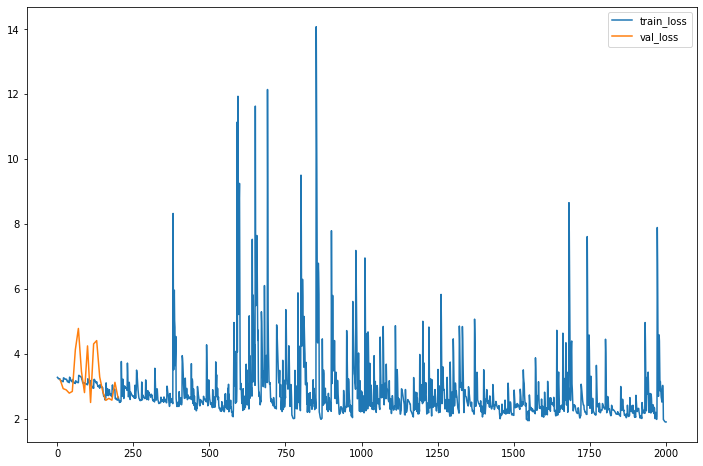

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(train_iter, train_total_losses, label='train_loss')
plt.plot(val_iter, val_total_losses, label='val_loss')
plt.legend()
plt.show()

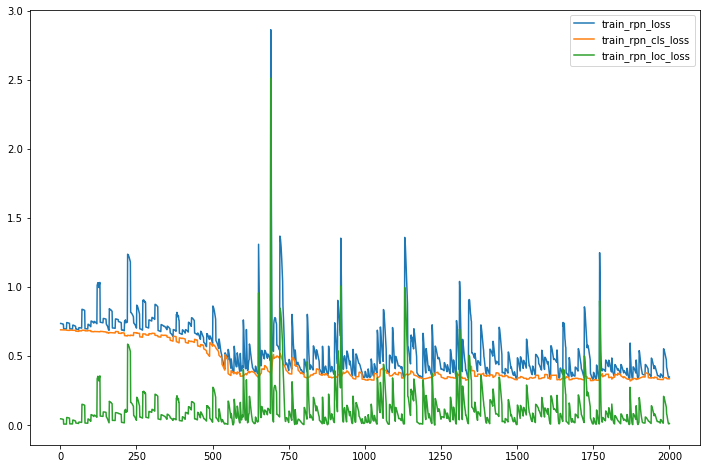

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(train_iter, rpn_losses, label='train_rpn_loss')
plt.plot(train_iter, rpn_cls_losses, label='train_rpn_cls_loss')
plt.plot(train_iter, rpn_loc_losses, label='train_rpn_loc_loss')
plt.legend()
plt.show()

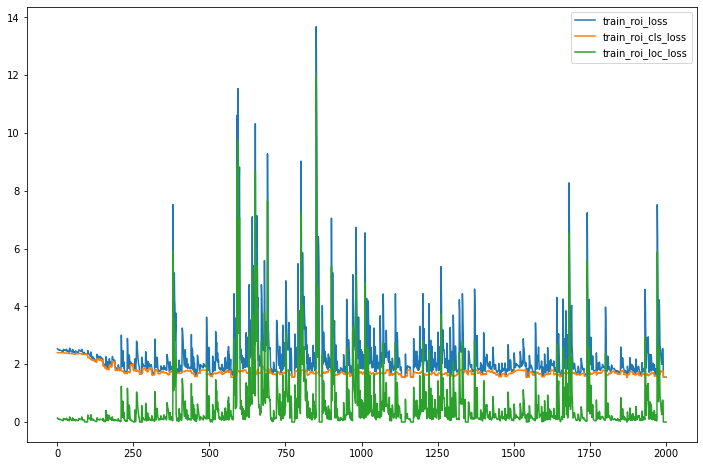

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(train_iter, roi_losses, label='train_roi_loss')
plt.plot(train_iter, roi_cls_losses, label='train_roi_cls_loss')
plt.plot(train_iter, roi_loc_losses, label='train_roi_loc_loss')
plt.legend()
plt.show()


# Test code

# Classification: 
Taking region of interest score (tensor) as input and calculates for each row the biggest score for each class. 
Returns a score list of which classes has been most presented in the roi_cls_score

[8 4 1 8 8 8 1 8 9 9]
plain spaghetti
0.0039313394
glass of water
0.003692793
slice of bread
0.002628761
plain spaghetti
0.0025200057
plain spaghetti
0.0024980858
plain spaghetti
0.002453706
slice of bread
0.0023195376
plain spaghetti
0.0022686198
plain rice
0.0021107781
plain rice
0.0019607698


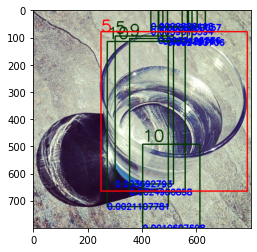

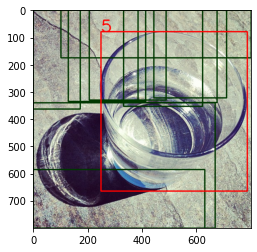

In [ ]:
# import importlib
# import bbox_predict #import the module here, so that it can be reloaded.
# importlib.reload(bbox_predict)
# from bbox_predict import bbox_predict
# importlib.reload(bbox_predict)
#test 
test_data=pd.read_csv('/content/drive/My Drive/test_anno_updated.csv')
test_data=filterData(test_data)
imageIndex = 10
img0 = cv2.imread('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/JPEGImages/'+str(test_data.fileID.iloc[imageIndex])+'.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 

 
# Select a row and transform back to pandas data frame
temp = test_data.iloc[imageIndex]
tt = temp.to_frame()
tt = tt.T

# bounding box true value for the image of choice and lables for bounding boxes
allArrays = []
allArraysL = [] 
labels1 = []
label= []
bbox = []
for i in range(tt.Nobj.values[0]):
  p_temp = tt[['bbx_'+str(i)+'_ymin','bbx_'+str(i)+'_xmin','bbx_'+str(i)+'_ymax','bbx_'+str(i)+'_xmax']].to_numpy()
  allArrays.append(p_temp)
  lableTemp = tt["bbx_"+str(i)+"_name"].map(lib_lab)
  allArraysL.append(lableTemp)
#[ymin, xmin, ymax, xmax] bounding box 
bbox0 = np.vstack(allArrays)
bbox0 = bbox0.astype(int)
label = np.vstack(allArraysL)

# change the bounding box coordinates 
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox0 = np.array(bbox)

# lables are stored as int in lib_lab and mapped into int 
labels1 = label.reshape(-1)

lib_lab = {"background": 0, "meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}

remove_background = True
# img = prepare_img(img0)
# out_map = VGG16(img)
img, roi_loc_pred, score, labels, roi, anchors = net.predict(img0, nms_thresh=0.7, n_test_pre_nms=100, n_test_post_nms=10, min_size=16, remove_background=remove_background)
img_clone = np.copy(img)
img_clone2 = np.copy(img)

if remove_background:
  lib_lab = {"meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}


out = net(img0, tt, anc_n_sample = anc_n_sample, n_sample = n_sample, anc_pos_ratio = anc_pos_ratio, pos_ratio = pos_ratio, pos_iou_thresh = pos_iou_thresh, anc_pos_iou_thresh = anc_pos_iou_thresh, anc_neg_iou_thresh = anc_neg_iou_thresh, neg_iou_thresh_hi=neg_iou_thresh_hi, neg_iou_thresh_lo=neg_iou_thresh_lo, nms_thresh = nms_thresh, n_train_pre_nms = n_train_pre_nms, n_train_post_nms = n_train_post_nms, min_size = min_size)

pos_index, neg_index, gt_roi_locs, gt_roi_labels, sample_roi, pos_roi_per_this_image = out['sampleROI']
roi = out['nms']
pred_anchor_locs, objectness_score, pred_cls_scores = out['RPN']

print(labels)

# Show final bboxes and labels
for i in range(len(roi_loc_pred[:,1])):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels[i]+1)]
    print(label)
    print(score[i])
    y0, x0, y1, x1 = roi_loc_pred[i].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)
    cv2.putText(img_clone, str(labels[i]+1), (x0, y0-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 55, 0),thickness=4)
    cv2.putText(img_clone, str(score[i]), (x0, y1+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),thickness=3)
# Show groundtruth and label
lib_lab = {"background": 0, "meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone)
plt.show()

# Show region proposals
for i in range(9):
    y0, x0, y1, x1 = roi[i].astype(int)
    cv2.rectangle(img_clone2, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)

# Show groundtruth and label
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone2, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone2, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone2)
plt.show()


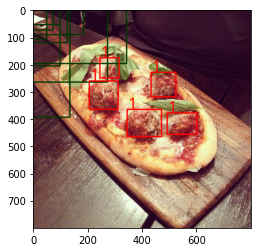

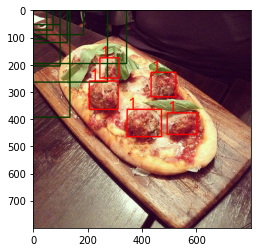

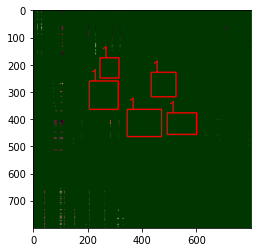

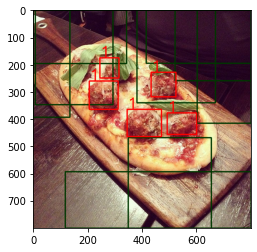

In [ ]:
from torchvision.ops import nms
anc_height = anchors[:, 2] - anchors[:, 0]
anc_width = anchors[:, 3] - anchors[:, 1]
anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

m = nn.Softmax(dim=1)
pred_cls_scores1 = m(pred_cls_scores[0])


# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

# objectness_score_numpy = pred_cls_scores1[:,1].cpu().data.numpy()

# Normalize
# pred_anchor_locs_numpy = (pred_anchor_locs_numpy - np.mean(pred_anchor_locs_numpy, axis=0)) / np.std(pred_anchor_locs_numpy, axis=0)

dy = pred_anchor_locs_numpy[:, 0::4] # anchor box dy
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
#print(w.shape)

# ROI sampling:
roi = np.zeros(pred_anchor_locs_numpy.shape)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
#print(roi.shape)
img_clone3 = np.copy(img)
# Show region proposals
for i in range(9):
    y0, x0, y1, x1 =roi[i].astype(int)
    cv2.rectangle(img_clone3, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)

# Show groundtruth and label
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone3, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone3, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone3)
plt.show()
# clip the predicted boxes to the image
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
# print(roi.shape, np.max(roi), np.min(roi))

# Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
#print(keep.shape, roi.shape, score.shape)

img_clone3 = np.copy(img)
# Show region proposals
for i in range(9):
    y0, x0, y1, x1 =roi[i].astype(int)
    cv2.rectangle(img_clone3, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)

# Show groundtruth and label
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone3, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone3, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone3)
plt.show()

# Sort all (proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
#print(order.shape)
#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
score = score[order]
img_clone3 = np.copy(img)
# Show region proposals
for i in range(1000):
    y0, x0, y1, x1 =roi[i].astype(int)
    cv2.rectangle(img_clone3, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)

# Show groundtruth and label
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone3, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone3, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone3)
plt.show()


keep = nms(torch.from_numpy(roi).cuda(),torch.from_numpy(score).cuda(),nms_thresh)
keep = keep[:n_train_post_nms]
roi = roi[keep.cpu().numpy()]



img_clone3 = np.copy(img)
# Show region proposals
for i in range(9):
    y0, x0, y1, x1 =roi[i].astype(int)
    cv2.rectangle(img_clone3, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)

# Show groundtruth and label
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone3, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone3, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone3)
plt.show()
